In [1]:
import sys
import os


# Add the parent directory of 'scripts' to sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)
import beneuro_pose_estimation.anipose.aniposeTools as aniposeTools

INFO:numexpr.utils:Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
aniposeTools.save_to_csv("M045_2024_11_20_11_15","/home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_pose_estimation_combined.h5","/home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_3d_predictions.csv")

INFO:root:3D predictions saved to CSV at /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_3d_predictions.csv


In [3]:
import h5py
points3d = h5py.File("/home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_pose_estimation_combined.h5", 'r')['points3d'][:]

In [9]:
file_path = "/home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_0_1000.h5"

In [5]:
points3d.shape

(30000, 1, 19, 3)

In [ ]:
with h5py.File(file_path, 'r') as h5_file:
    # Recursively list all groups and datasets
    def print_structure(name, obj):
        print(f"{name}: {type(obj)}")
    h5_file.visititems(print_structure)

frames: <class 'h5py._hl.dataset.Dataset'>
tracks: <class 'h5py._hl.dataset.Dataset'>


In [13]:
with h5py.File(file_path, 'r') as h5_file:
    print(h5_file["tracks"])

<HDF5 dataset "tracks": shape (1000, 1, 19, 3), type "<f8">


In [16]:
with h5py.File(file_path, 'r') as h5_file:
    print(h5_file["frames"][1])

1000


In [6]:
import sleap_anipose as slap
output_file = file_path = "/home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_0_1000.h5"
calib_file_path = "/home/il620/beneuro_pose_estimation/projects/calibrations/calibration_2024_11_20_11_25.toml"
start = 0 
end = 1000
session = "M045_2024_11_20_11_15"
project_dir = "/home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15"
reproj_output_file = f"{project_dir}/{session}_reprojections_{start}_{end}.h5"


slap.reproject(p3d=output_file ,calib= calib_file_path,frames=(start, end),fname=reproj_output_file)
        # #  output: (n_cams, n_frames, n_tracks, n_nodes, 2)

array([[[[[ 397.74867329,  147.75311613],
          [ 527.32704281,  286.91513125],
          [ 423.77053046,  456.64745747],
          ...,
          [ 503.06126364,  375.72079149],
          [ 410.39835894,  413.70634969],
          [ 212.58215671,  358.95124271]]],


        [[[ 398.68185726,  148.16908685],
          [ 532.26708284,  280.46628432],
          [ 418.59956162,  466.18957258],
          ...,
          [ 514.12125845,  375.23826673],
          [ 425.04200453,  430.11045143],
          [ 213.04961782,  358.1500361 ]]],


        [[[ 399.60409424,  148.5911343 ],
          [ 536.35945998,  275.54044837],
          [ 414.97402914,  473.97762831],
          ...,
          [ 521.90942526,  375.48781898],
          [ 437.98428755,  441.07630998],
          [ 213.65924463,  357.64116965]]],


        ...,


        [[[ 399.37672017,  148.65217145],
          [ 536.29811565,  273.37218719],
          [ 407.2600634 ,  480.89923094],
          ...,
          [ 522.77636308,  381.

In [8]:
import h5py
with h5py.File(reproj_output_file , 'r') as h5_file:
    # Recursively list all groups and datasets
    def print_structure(name, obj):
        print(f"{name}: {type(obj)}")
    h5_file.visititems(print_structure)

Camera_Back_Right: <class 'h5py._hl.dataset.Dataset'>
Camera_Front_Left: <class 'h5py._hl.dataset.Dataset'>
Camera_Front_Right: <class 'h5py._hl.dataset.Dataset'>
Camera_Side_Left: <class 'h5py._hl.dataset.Dataset'>
Camera_Side_Right: <class 'h5py._hl.dataset.Dataset'>
Camera_Top_Left: <class 'h5py._hl.dataset.Dataset'>


In [9]:
with h5py.File(reproj_output_file, 'r') as h5_file:
    print(h5_file["Camera_Back_Right"])

<HDF5 dataset "Camera_Back_Right": shape (1000, 1, 19, 2), type "<f8">


In [3]:
session = "M045_2024_11_20_11_15"
aniposeTools.run_pose_estimation(session)

INFO:root:Running pose estimation on M045_2024_11_20_11_15
INFO:root:Using calibration folder: /mnt/rds/bb2020/projects/beneuro/live/raw/pose-estimation/calibration-videos/camera_calibration_2024_11_20_11_25 for session M045_2024_11_20_11_35
/home/il620/beneuro_pose_estimation/projects/calibrations/calibration_2024_11_20_11_25.toml
INFO:root:Calibration file already exists: /home/il620/beneuro_pose_estimation/projects/calibrations/calibration_2024_11_20_11_25.toml
INFO:root:Configuration file already exists at /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/config.toml
Index(['fnum', 'shoulder_center_x', 'shoulder_center_y', 'shoulder_center_z',
       'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_paw_x',
       'left_paw_y', 'left_paw_z', 'right_shoulder_x', 'right_shoulder_y',
       'right_shoulder_z', 'right_elbow_x', 'right_elbow_y', 'right_elbow_z',
       'right_paw_x', 'right_paw_y', 'right_paw_z', 'hip_center_x',
       'hi

<Figure size 2000x500 with 0 Axes>

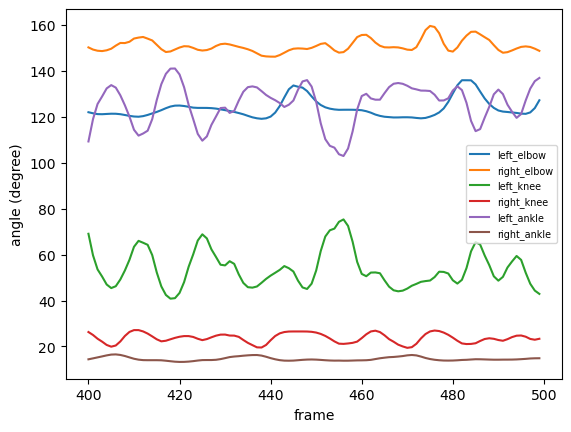

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
outname = "/home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_pose_and_angles.csv"
project_dir = "/home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15"
df = pd.read_csv(outname)
# only plot left_elbow, right_elbow, left_knee, right_knee
df = df[['left_elbow', 'right_elbow', 'left_knee', 'right_knee',"left_ankle","right_ankle"]]
# only plot first 100 frames
df = df[400:500]
# change figure size
plt.figure(figsize=(20, 5))
df.plot()
plt.ylabel('angle (degree)')
plt.xlabel('frame')
# change the size of legend
plt.legend(fontsize='x-small')
# save figure as pdf
plt.savefig(f'{project_dir}/angles.pdf')
plt.show()

In [ ]:
session = "M045_2024_11_20_11_15"
aniposeTools.convert_2Dpred_to_h5(session)
# RDS/projects/beneuro/live/raw/M043/M043_2024_10_23_11_15/M043_2024_10_23_11_15_cameras

INFO:numexpr.utils:Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.

Exporting to SLEAP Analysis file...
	track_names: 0
	node_names: 19
	edge_names: 18
	edge_inds: 18
	tracks: (30013, 19, 2, 1)
	track_occupancy: (1, 30013)
	point_scores: (30013, 19, 1)
	instance_scores: (30013, 1)
	tracking_scores: (30013, 1)
	labels_path: /home/il620/beneuro_pose_estimation/projects/predictions/M045_2024_11_20_11_15_Camera_Top_Left.slp.predictions.slp
	video_path: /mnt/rds/bb2020/projects/beneuro/live/raw/M045/M045_2024_11_20_11_15/Recording_2024-11-20T111527/Camera_0.avi
	video_ind: 0
	provenance: {"model_paths": ["/mnt/rds/bb2020/projects/beneuro/live/raw/pose-estimation/models/h1_new_setup/Camera_Top_Left/training_config.json"], "predictor": "SingleInstancePredictor", "sleap_version": "1.3.4", "platform": "Linux-5.15.0-117-generic-x86_64-with-debian-bullseye-sid", "command": "/home/il620/miniconda3/

In [2]:
calib_file_path = aniposeTools.get_most_recent_calib("M045_2024_11_20_11_15")

INFO:root:Using calibration folder: /mnt/rds/bb2020/projects/beneuro/live/raw/pose-estimation/calibration-videos/camera_calibration_2024_09_05_13_10 for session M045_2024_11_20_11_15
/home/il620/beneuro_pose_estimation/projects/calibrations/calibration_2024_09_05_13_10.toml
/mnt/rds/bb2020/projects/beneuro/live/raw/pose-estimation/calibration-videos/camera_calibration_2024_09_05_13_10/Recording_2024-09-05T131252/Camera_4.avi


 13%|███▍                       | 2322/18001 [00:07<00:50, 310.09it/s]


KeyboardInterrupt: 

In [6]:
import h5py
h5_analysis_file = f"/home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_Camera_Back_Right.analysis.h5"
with h5py.File(h5_analysis_file, 'r') as f: 
        print(f['tracks'].shape)

(1, 2, 19, 30013)


In [2]:
recent_calib_folder = "/mnt/rds/bb2020/projects/beneuro/live/raw/pose-estimation/calibration-videos/camera_calibration_2024_11_20_11_25/Recording_2024-11-20T113135"
calib_file_path = "/home/il620/beneuro_pose_estimation/beneuro_pose_estimation/projects/calibrations/calibration_2024_11_20_11_25.toml"
aniposeTools.get_calib_file(recent_calib_folder, calib_file_path)

/mnt/rds/bb2020/projects/beneuro/live/raw/pose-estimation/calibration-videos/camera_calibration_2024_11_20_11_25/Recording_2024-11-20T113135/Camera_4.avi


  4%|█▏                           | 715/18013 [00:08<03:33, 81.00it/s]


KeyboardInterrupt: 

In [ ]:
calib_file_path = aniposeTools.get_most_recent_calib(session)

In [4]:
import h5py
fname = "/home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_1000_2000.h5"
with h5py.File(fname, 'r') as f:
    print(f.keys())  # List datasets in the file
    print(f["tracks"].shape)
    # if 'points3d' in f:
    #     print(f['points3d'].shape)  # Check the shape of the dataset
    # else:
    #     print("Dataset 'points3d' is missing.")

<KeysViewHDF5 ['frames', 'tracks']>
(1000, 1, 19, 3)


In [2]:
calib_file_path = "/home/il620/beneuro_pose_estimation/projects/calibrations/calibration_2024_11_20_11_25.toml"
session = "M045_2024_11_20_11_15"
project_dir = f"/home/il620/beneuro_pose_estimation/projects/complete_projects/{session}"
aniposeTools.compute_3Dpredictions(session, project_dir, calib_file_path)

/home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15
0, 1000


100%|█████████████████████████| 19000/19000 [00:03<00:00, 5018.27it/s]


INFO:numba.core.transforms:finding looplift candidates
INFO:numba.core.transforms:finding looplift candidates
INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_0_1000.h5
1000, 2000


100%|█████████████████████████| 19000/19000 [00:03<00:00, 5910.69it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_1000_2000.h5
2000, 3000


100%|█████████████████████████| 19000/19000 [00:02<00:00, 7392.81it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_2000_3000.h5
3000, 4000


100%|█████████████████████████| 19000/19000 [00:03<00:00, 5600.60it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_3000_4000.h5
4000, 5000


100%|█████████████████████████| 19000/19000 [00:05<00:00, 3176.35it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_4000_5000.h5
5000, 6000


100%|█████████████████████████| 19000/19000 [00:06<00:00, 2970.04it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_5000_6000.h5
6000, 7000


100%|█████████████████████████| 19000/19000 [00:03<00:00, 6284.26it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_6000_7000.h5
7000, 8000


100%|█████████████████████████| 19000/19000 [00:02<00:00, 8809.36it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_7000_8000.h5
8000, 9000


100%|█████████████████████████| 19000/19000 [00:02<00:00, 6385.94it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_8000_9000.h5
9000, 10000


100%|█████████████████████████| 19000/19000 [00:11<00:00, 1604.24it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_9000_10000.h5
10000, 11000


100%|█████████████████████████| 19000/19000 [00:02<00:00, 6488.91it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_10000_11000.h5
11000, 12000


100%|█████████████████████████| 19000/19000 [00:02<00:00, 7991.46it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_11000_12000.h5
12000, 13000


100%|█████████████████████████| 19000/19000 [00:02<00:00, 8099.09it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_12000_13000.h5
13000, 14000


100%|█████████████████████████| 19000/19000 [00:02<00:00, 8115.26it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_13000_14000.h5
14000, 15000


100%|█████████████████████████| 19000/19000 [00:02<00:00, 7779.54it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_14000_15000.h5
15000, 16000


100%|█████████████████████████| 19000/19000 [00:02<00:00, 7759.30it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_15000_16000.h5
16000, 17000


100%|█████████████████████████| 19000/19000 [00:02<00:00, 8021.12it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_16000_17000.h5
17000, 18000


100%|█████████████████████████| 19000/19000 [00:02<00:00, 8893.93it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_17000_18000.h5
18000, 19000


100%|█████████████████████████| 19000/19000 [00:02<00:00, 7711.55it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_18000_19000.h5
19000, 20000


100%|█████████████████████████| 19000/19000 [00:02<00:00, 8707.05it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_19000_20000.h5
20000, 21000


100%|██████████████████████████| 19000/19000 [02:39<00:00, 118.90it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_20000_21000.h5
21000, 22000


100%|██████████████████████████| 19000/19000 [01:09<00:00, 275.36it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_21000_22000.h5
22000, 23000


100%|███████████████████████████| 19000/19000 [06:54<00:00, 45.82it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_22000_23000.h5
23000, 24000


100%|█████████████████████████| 19000/19000 [00:03<00:00, 5751.37it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_23000_24000.h5
24000, 25000


100%|█████████████████████████| 19000/19000 [00:03<00:00, 5679.28it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_24000_25000.h5
25000, 26000


100%|█████████████████████████| 19000/19000 [00:02<00:00, 8790.07it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_25000_26000.h5
26000, 27000


100%|█████████████████████████| 19000/19000 [00:02<00:00, 8602.34it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_26000_27000.h5
27000, 28000


100%|█████████████████████████| 19000/19000 [00:03<00:00, 6148.64it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_27000_28000.h5
28000, 29000


100%|█████████████████████████| 19000/19000 [00:04<00:00, 3805.30it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_28000_29000.h5
29000, 30000


100%|█████████████████████████| 19000/19000 [00:02<00:00, 8909.35it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_29000_30000.h5
30000, 30013


100%|██████████████████████████████| 247/247 [00:00<00:00, 372.00it/s]


INFO:root:3D prediction file created: /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_triangulation_30000_30013.h5


KeyError: "Unable to open object (object 'points3d' doesn't exist)"

In [3]:
import numpy as np
session = "M045_2024_11_20_11_15"
project_dir = f"/home/il620/beneuro_pose_estimation/projects/complete_projects/{session}"
windows = np.arange(0, 30013, 1000)
aniposeTools.combine_h5_files(session,windows, project_dir)

INFO:root:Combined 3D predictions saved at /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_pose_estimation_combined.h5


In [5]:
aniposeTools.save_to_csv(session,f"{project_dir}/{session}_pose_estimation_combined.h5", f"{project_dir}/{session}_3d_predictions.csv")
        

INFO:root:3D predictions saved to CSV at /home/il620/beneuro_pose_estimation/projects/complete_projects/M045_2024_11_20_11_15/M045_2024_11_20_11_15_3d_predictions.csv


In [ ]:

# add angles
# see what intermediate files could be deleted 


